# Análisis del perfil crediticio de clientes bancarios

## Objetivo del análisis

La entidad bancaria nos proporciona información sobre clientes a los cuales se le han concedido, o no, prestamos. El objetivo que nos pide la empresa es predecir la concesión de préstamos para nuevos solicitantes. También quieren obtener la puntuación de riesgo.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna as op
import xgboost as xgb
import pickle
from warnings import simplefilter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, XGBRegressor
pd.options.mode.chained_assignment = None
simplefilter("ignore", category=RuntimeWarning)

# Cargar datos de CSV en variable "datos"
datos = pd.read_csv('loan_data.csv')
# Guardarnos en una variable el nombre de las columnas objetivos "loan_status" y "risk_score"
valor_objetivo1 = 'loan_status'
valor_objetivo2 = 'risk_score'

datos.head()


,age,gender,education,income,yrs_exp,ownership,amount,purpose,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               45000 non-null  float64
 1   gender            45000 non-null  object 
 2   education         45000 non-null  object 
 3   income            45000 non-null  float64
 4   yrs_exp           45000 non-null  int64  
 5   ownership         45000 non-null  object 
 6   amount            45000 non-null  float64
 7   purpose           44962 non-null  object 
 8   int_rate          45000 non-null  float64
 9   percent_income    45000 non-null  float64
 10  cred_hist_length  45000 non-null  float64
 11  risk_score        45000 non-null  int64  
 12  previous_loans    45000 non-null  object 
 13  loan_status       45000 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 4.8+ MB


In [4]:
datos = datos.astype({'age': 'int64'})

for i in datos:
    if datos[i].dtype != 'object':
      print(datos[i].describe())

count    45000.000000
mean        27.764178
std          6.045108
min         20.000000
25%         24.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: age, dtype: float64
count    4.500000e+04
mean     8.031905e+04
std      8.042250e+04
min      8.000000e+03
25%      4.720400e+04
50%      6.704800e+04
75%      9.578925e+04
max      7.200766e+06
Name: income, dtype: float64
count    45000.000000
mean         5.410333
std          6.063532
min          0.000000
25%          1.000000
50%          4.000000
75%          8.000000
max        125.000000
Name: yrs_exp, dtype: float64
count    45000.000000
mean      9583.157556
std       6314.886691
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12237.250000
max      35000.000000
Name: amount, dtype: float64
count    45000.000000
mean        11.006606
std          2.978808
min          5.420000
25%          8.590000
50%         11.010000
75%         12.990000
max         20.000000
Name: 

## Limpieza de datos

### Limpieza de valores nulos

Vamos a revisar las columnas que contienen valores nulos y ver cual va a ser nuestra metodología respecto al tratado de estos datos. Lo más común es que si el porcentaje de datos nulo es bajo, se eliminarán las filas que contengan cualquier valor de este tipo.

In [5]:
valores_nulos = datos.isnull().sum().sort_values(ascending=False)
# Añadimos "reset_index" para numerar las filas resultantes
ratio_nulos = (valores_nulos / len(datos)).reset_index()
ratio_nulos.columns = ['Caracteristica', 'RatioNulos']
ratio_nulos

,Caracteristica,RatioNulos
0,purpose,0.000844
1,age,0.000000
2,education,0.000000
3,income,0.000000
4,yrs_exp,0.000000
5,gender,0.000000
6,ownership,0.000000
7,amount,0.000000
8,int_rate,0.000000
9,percent_income,0.000000


In [6]:
datos = datos.dropna(subset=['purpose'])

Una vez revisados los nulos por columnas, observamos que todos se situan en la columna "purpose". Nuestra manera de procesar, como hemos dicho anteriormente, es eliminarlos, ya que representan un valor muy bajo (0.08%) y no afecta a la resolución de este análisis.

### Gestión de outliers

Procedemos a revisar los datos que tenemos y encontrar valores atípicos. Dependiendo de los datos, los trataremos de una manera u otra. Primero, observaremos los outliers a través de un boxplot, y dependiendo del resultado, sacaremos el Z-score de cada columna con los valores más atípicos.

Tras ver en el Z-score, vemos varios valores que se alejan bastante de la media de las columnas "age", "yrs_exp", "risk_score" e "income". Procedemos a sacar un boxplot para ver qué valor tienen estos outliers.

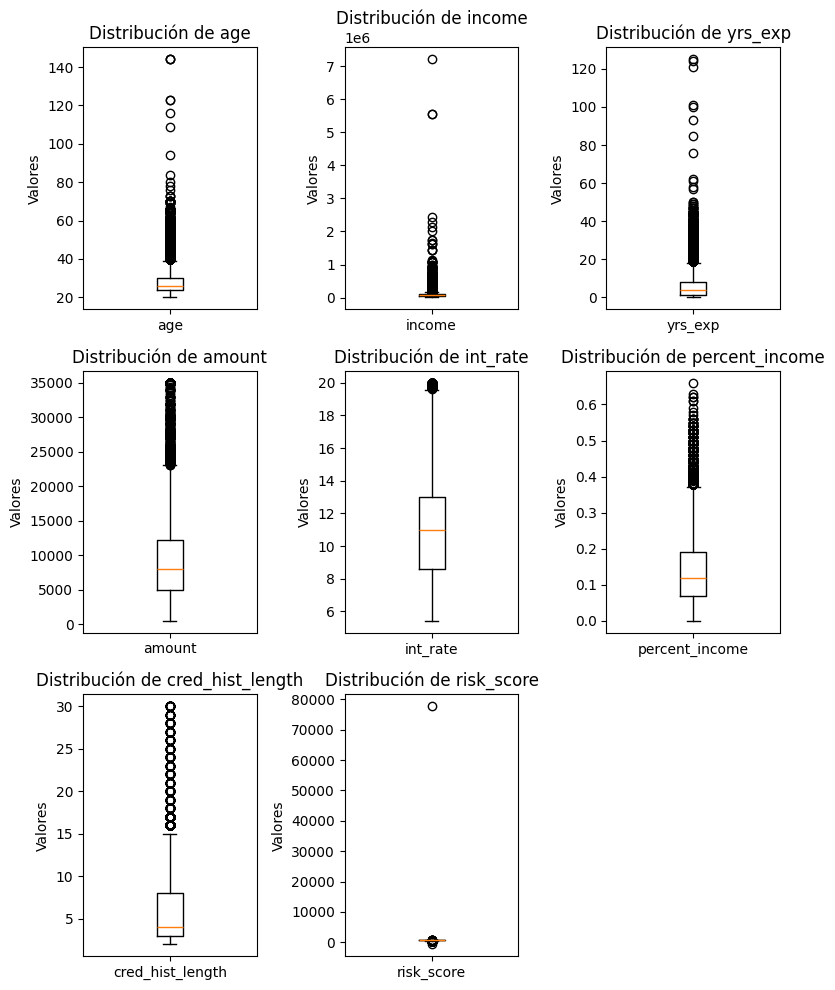

In [7]:
categorias = ['age', 'income', 'yrs_exp', 'amount', 'int_rate', 'percent_income', 'cred_hist_length', 'risk_score']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 10))
axes = axes.flatten()
for i, var in enumerate(categorias):
 axes[i].boxplot(datos[var], tick_labels=[var])
 axes[i].set_title(f'Distribución de {var}')
 axes[i].set_ylabel('Valores')
for j in range(len(categorias), len(axes)):
 axes[j].axis('off')
plt.tight_layout()
plt.show()

In [8]:
categorias = ['age', 'income', 'yrs_exp', 'amount', 'int_rate', 'percent_income', 'cred_hist_length', 'risk_score']

def obtener_outliers(categorias):
    listaValoresOutliers = {}

    for i in categorias:
        media = np.mean(datos[i])
        desviacion = np.std(datos[i])
        arrayZscore = []
        for elemento in datos[i].values:
            z = abs(elemento - media) / desviacion
            if z > 9.5:
                arrayZscore.append(elemento)
        listaValoresOutliers[i] = arrayZscore

    for i in listaValoresOutliers:
        print("Outliers en la columna", i)
        valoresUnicosLista = set(listaValoresOutliers[i])
        for j in valoresUnicosLista:
            print(j)

obtener_outliers(categorias)

Outliers en la columna age
109
144
116
123
94
Outliers en la columna income
915203.0
936964.0
936965.0
2139143.0
1067921.0
1440915.0
2280980.0
2448661.0
961176.0
2012954.0
846491.0
1138723.0
1081254.0
937126.0
1635757.0
994605.0
5556399.0
936880.0
1081139.0
915386.0
1741243.0
900803.0
845636.0
1076036.0
1097671.0
5545545.0
1728974.0
1440982.0
1080918.0
935136.0
994533.0
1621992.0
1440746.0
864746.0
936941.0
890990.0
936815.0
860787.0
850679.0
1080952.0
1081082.0
7200766.0
1661567.0
Outliers en la columna yrs_exp
100
101
76
93
85
121
124
125
Outliers en la columna amount
Outliers en la columna int_rate
Outliers en la columna percent_income
Outliers en la columna cred_hist_length
Outliers en la columna risk_score
77710


Tras sacar el Z-score y revisar el boxplot, le indicamos al cliente los valores que podrían ser outliers. El cliente nos indica que de las columnas anteriores, las que tienen outliers posiblemente erroneos son: "age", "yrs_exp", "risk_score". El resto de campos son valores viables y que se pueden dar en la realidad.

Ahora, queda en nuestro criterio el rango de filtrado de los valores. Revisamos cuales serían valores lógicos, cuales se salen de la realidad y aplicamos el filtro.

In [9]:
totalOutliersAge = datos[datos['age'] > 100].value_counts('age').sum()
percentOutliersAge = (totalOutliersAge/datos.value_counts().sum()) * 100
print(f"Porcentaje de outliers de la columna 'age' {"%.2f" % percentOutliersAge}%")

totalOutliersYrsExp = datos[datos['yrs_exp'] > 60].value_counts('yrs_exp').sum()
percentOutliersYrsExp = (totalOutliersYrsExp/datos.value_counts().sum()) * 100
print(f"Porcentaje de outliers de la columna 'yrs_exp' {"%.2f" % percentOutliersYrsExp}%")

totalOutliersRiskScore = datos[(datos['risk_score'] > 10000) | (datos['risk_score'] < 0)].value_counts('risk_score').sum()
percentOutliersRiskScore = (totalOutliersRiskScore/datos.value_counts().sum()) * 100
print(f"Porcentaje de outliers de la columna 'risk_score' {"%.2f" % percentOutliersRiskScore}%")

sumaTotalOutliers = percentOutliersAge + percentOutliersYrsExp + percentOutliersRiskScore

print(f"Suma total de porcentajes de outliers: {"%.2f" % sumaTotalOutliers}%")

Porcentaje de outliers de la columna 'age' 0.02%
Porcentaje de outliers de la columna 'yrs_exp' 0.02%
Porcentaje de outliers de la columna 'risk_score' 0.00%
Suma total de porcentajes de outliers: 0.04%


Una vez aplicados los filtros, hemos sacado la cantidad de outliers por columna para ver si es un porcentaje grande o no. Vistos estos porcentajes, apenas suman un 0.04%, por lo que el método a ejecutar es eliminar estos registros.

In [10]:
datos = datos[datos['age'] <= 100]

datos = datos[datos['yrs_exp'] <= 60]

datos = datos[(datos['risk_score'] <= 10000) & (datos['risk_score'] >= 0)]

Una vez eliminados estos outliers, volvemos a mostrar los gráficos anteriores con las modificaciones.

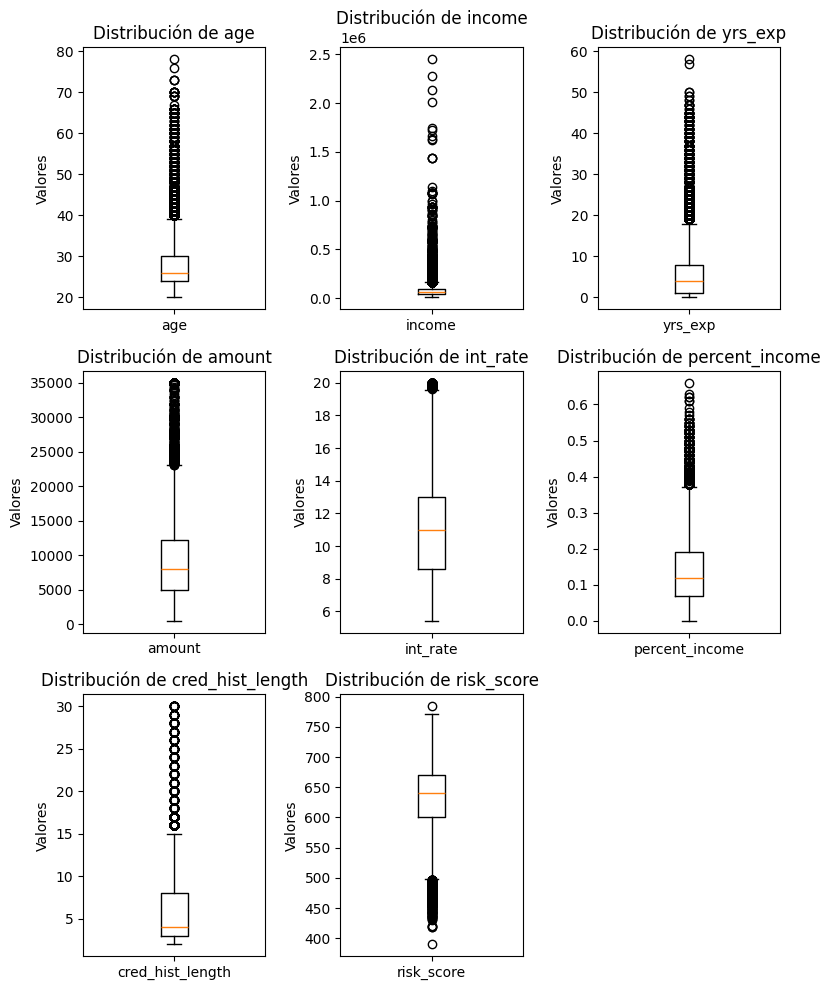

In [11]:
categorias = ['age', 'income', 'yrs_exp', 'amount', 'int_rate', 'percent_income', 'cred_hist_length', 'risk_score']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 10))
axes = axes.flatten()
for i, var in enumerate(categorias):
 axes[i].boxplot(datos[var], tick_labels=[var])
 axes[i].set_title(f'Distribución de {var}')
 axes[i].set_ylabel('Valores')
for j in range(len(categorias), len(axes)):
 axes[j].axis('off')
plt.tight_layout()
plt.show()

Después de volver a sacar los gráficos y realizar la limpieza de outliers, vemos que los valores están más cercanos a la media, pero siguen habiendo outliers. Tras conversar con cliente, los outliers que vemos son valores posibles, reales y que se dan en el modelo de datos, por lo que damos finalizada la parte de limpieza de datos.

## Ingeniería de características

### Tratar las variables categóricas

Vamos a proceder a revisar las variables categóricas (textuales), ver si hay valores erróneos, tratarlos, y una vez tratados, convertir estos valores de texto en valor numérico.

In [12]:
valoresCategoricos = datos.select_dtypes(include=['object']).columns

for i in valoresCategoricos:
    print(datos[i].value_counts())

gender
male      24817
female    20132
femal         1
Name: count, dtype: int64
education
Bachelor       13381
Associate      12017
High School    11956
Master          6975
Doctorate        621
Name: count, dtype: int64
ownership
RENT        23406
MORTGAGE    18476
OWN          2950
OTHER         117
OWN             1
Name: count, dtype: int64
purpose
EDUCATION            9142
MEDICAL              8540
VENTURE              7813
PERSONAL             7544
DEBTCONSOLIDATION    7132
HOMEIMPROVEMENT      4779
Name: count, dtype: int64
previous_loans
Yes    22849
No     22101
Name: count, dtype: int64


Tras revisar los valores categóricos, hemos observado que hay errores de tipografía. Los pasos que vamos a seguir son:
- En la columna "gender" hemos visto que hay un valor llamado "femal", cuando debería de ser "female", por lo que vamos a sustituir todos los valores de "femal" a "female".
- En la columna "ownership", observamos un valor erróneo que es "OWN ", ya que tiene un espacio. Vamos a sustituir los valores "OWN ", por su correcto valor "OWN".

In [13]:
datos['gender'] = datos['gender'].replace('femal','female')
datos['ownership'] = datos['ownership'].str.strip()

Una vez solucionados los errores de tipografía, vamos a codificar los valores de texto. Vamos a aplicar un OneHotEncoder a las columnas de "gender", "ownership" y "previous_loans", ya que son valores que no tienen orden de importancia. El resto de valores les hacemos un LabelEncoder, para agilizar el proceso de conversión.

In [14]:
le = LabelEncoder()
categoriasLabelEncoder = ['education', 'purpose']
categoriasDummies = ['gender', 'ownership', 'previous_loans']

for i in categoriasDummies:
    datos = pd.get_dummies(datos, columns=[i], prefix=i, dtype=int)

datos.drop('gender_female', axis=1, inplace=True)
datos.drop('previous_loans_No', axis=1, inplace=True)

for i in categoriasLabelEncoder:
    datos[i] = le.fit_transform(datos[i])

datos.head()

,age,education,income,yrs_exp,amount,purpose,int_rate,percent_income,cred_hist_length,risk_score,loan_status,gender_male,ownership_MORTGAGE,ownership_OTHER,ownership_OWN,ownership_RENT,previous_loans_Yes
0,22,4,71948.0,0,35000.0,4,16.02,0.49,3.0,561,1,0,0,0,0,1,0
1,21,3,12282.0,0,1000.0,1,11.14,0.08,2.0,504,0,0,0,0,1,0,1
2,25,3,12438.0,3,5500.0,3,12.87,0.44,3.0,635,1,0,1,0,0,0,0
3,23,1,79753.0,0,35000.0,3,15.23,0.44,2.0,675,1,0,0,0,0,1,0
4,24,4,66135.0,1,35000.0,3,14.27,0.53,4.0,586,1,1,0,0,0,1,0


En la muestra de los datos, podemos observar que los campos de texto ya los hemos convertido en valores numéricos para su posterior tratado.

### Selección de características

Vamos a generar un mapa de calor para ver que características son relevantes o no, tanto para 'loan_status' como para 'risk_score', y de cuantas podríamos prescindir.

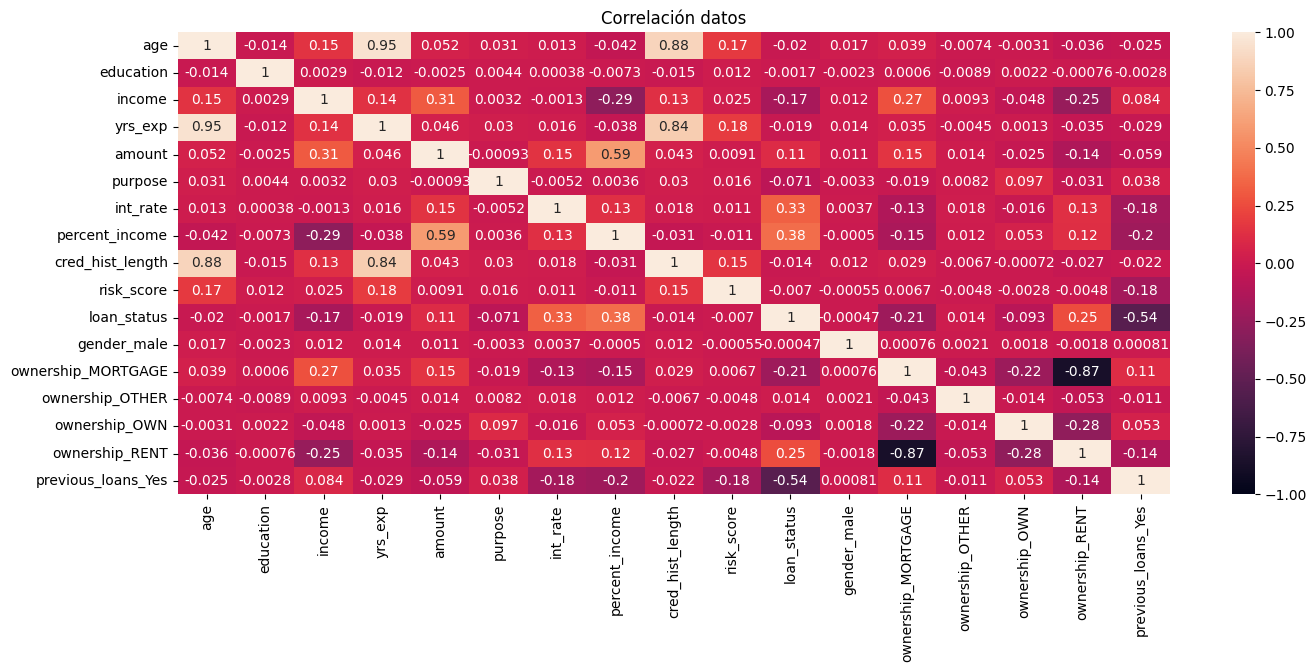

In [15]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(datos.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlación datos')
plt.show()

## Trabajando con loan_status

A partir del mapa de calor anterior, hemos revisado que columas tienen más correlación con loan_status, y las hemos seleccionado para continuar con nuestro modelo. Hemos elegido las columnas que están por debajo de -0.17 y por encima de 0.25.

In [16]:
columnasRelevantesLoanStatus = ['income', 'int_rate', 'percent_income', 'ownership_MORTGAGE', 'ownership_RENT', 'previous_loans_Yes']

datosLoanStatus = datos[columnasRelevantesLoanStatus + [valor_objetivo1]]
datosLoanStatusNormalized = datos[columnasRelevantesLoanStatus + [valor_objetivo1]]

datosLoanStatus.head()

,income,int_rate,percent_income,ownership_MORTGAGE,ownership_RENT,previous_loans_Yes,loan_status
0,71948.0,16.02,0.49,0,1,0,1
1,12282.0,11.14,0.08,0,0,1,0
2,12438.0,12.87,0.44,1,0,0,1
3,79753.0,15.23,0.44,0,1,0,1
4,66135.0,14.27,0.53,0,1,0,1


### Escalado y normalización de datos

Hemos decidido hacer dos datasets: uno sin los valores escalados y otro con los valores escalados, porque debemos averiguar cual va a ser el mejor modelo para este caso de uso. No podemos limitarnos solo a los arboles de decisión ya que el resto de modelos que no son de este tipo, funcionan mejor con el escalado de valores.

In [17]:
se = StandardScaler()

for i in columnasRelevantesLoanStatus:
    datosLoanStatusNormalized[i] = se.fit_transform(datosLoanStatusNormalized[[i]])

datosLoanStatusNormalized.head()

,income,int_rate,percent_income,ownership_MORTGAGE,ownership_RENT,previous_loans_Yes,loan_status
0,-0.125933,1.683323,4.017959,-0.835399,0.959400,-1.016782,1
1,-1.067957,0.045226,-0.684778,-0.835399,-1.042318,0.983495,0
2,-1.065494,0.625945,3.444454,1.197032,-1.042318,-1.016782,1
3,-0.002705,1.418139,3.444454,-0.835399,0.959400,-1.016782,1
4,-0.217710,1.095891,4.476762,-0.835399,0.959400,-1.016782,1


### Análisis exploratorio de datos

C:\Users\ESP\AppData\Local\Temp\ipykernel_12368\235306701.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=variable_objetivo, data=datos, ax=extra_ax, palette='muted')


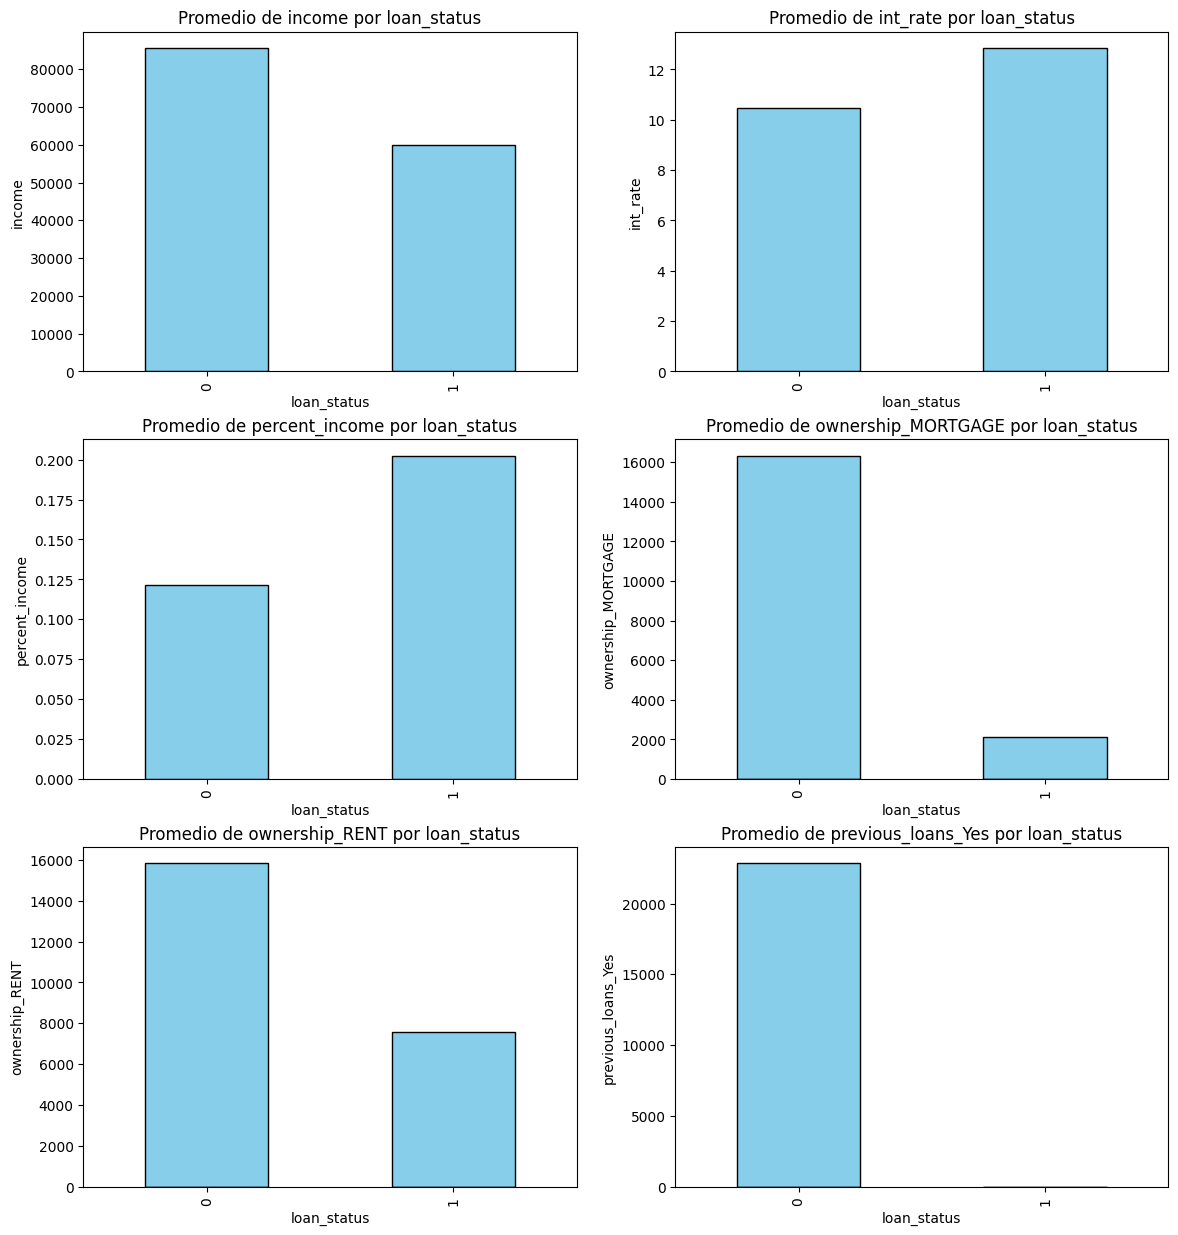

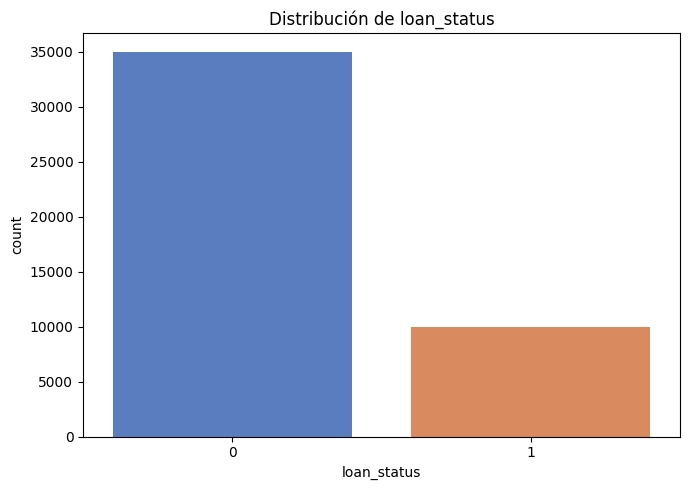

In [18]:
def graficar_correlacion_categorica(datos, columnas, variable_objetivo):
    n = len(columnas)
    filas = (n + 1) // 2 
    fig, ax = plt.subplots(nrows=filas, ncols=2, figsize=(14, 5 * filas))
    ax = ax.flatten()
    
    for i, columna in enumerate(columnas):
        if columna in ['ownership_MORTGAGE', 'ownership_RENT', 'previous_loans_Yes']:
            categoria = datos.groupby(variable_objetivo)[columna].sum()
            categoria.plot(kind='bar', ax=ax[i], color='skyblue', edgecolor='black')
            ax[i].set_title(f"{columna} por {variable_objetivo}")
            ax[i].set_ylabel(columna)
            ax[i].set_xlabel(variable_objetivo)
        if datos[columna].dtype in ['int64', 'float64']: 
            # Creamos un barplot agregando por promedio o conteo
            promedio_por_categoria = datos.groupby(variable_objetivo)[columna].mean()
            promedio_por_categoria.plot(kind='bar', ax=ax[i], color='skyblue', edgecolor='black')
            ax[i].set_title(f"Promedio de {columna} por {variable_objetivo}")
            ax[i].set_ylabel(columna)
            ax[i].set_xlabel(variable_objetivo)
        else:
            sns.countplot(x=columna, hue=variable_objetivo, data=datos, ax=ax[i], palette='viridis')
            ax[i].set_title(f"{columna} distribución por {variable_objetivo}")
    
    # Histograma de la variable objetivo
    if len(columnas) % 2 != 0:  # Si sobra un gráfico, lo usamos para el histograma.
        sns.countplot(x=variable_objetivo, data=datos, ax=ax[-1], palette='muted')
        ax[-1].set_title(f"Distribución de {variable_objetivo}")
    else:  # Si no sobra, creamos un gráfico adicional.
        fig, extra_ax = plt.subplots(1, 1, figsize=(7, 5))
        sns.countplot(x=variable_objetivo, data=datos, ax=extra_ax, palette='muted')
        extra_ax.set_title(f"Distribución de {variable_objetivo}")
    
    plt.tight_layout()
    plt.show()

graficar_correlacion_categorica(datos, columnasRelevantesLoanStatus, valor_objetivo1)

Tras hacer la comparativa de las columnas que hemos seleccionado con la columna objetivo, estas han sido nuestras conclusiones:

- Cuanto más bajo es el valor de 'income', más concesiones de prestamo se han hecho.
- Si ha tenido previamente un préstamo (previous_loans_Yes), se puede observar que no se le concede uno nuevo.

## Desarrollo del modelo para loan_status

A continuación vamos a utilizar diferentes modelos para predecir la variable loan_status. Los modelos a utilizar para hacer la predicción de loan_status son orientados a clasificación. También incluiremos un entrenamiento de hiperparámetros para obtener los mejores resultados. Nuestro primer paso será ejecutar un primer modelo aleatorio para analizar los scores de su resultado y ver qué pasos seguir dependiendo de estos valores.

In [19]:
def train_validation(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train.astype(int))
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_pred, y_test)
    print(classification_report(y_pred, y_test.astype(int)))
    print('score_test = ', model.score(X_test, y_test.astype(int)))
    print('score_train = ', model.score(X_train, y_train.astype(int)))
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
    xticklabels=["No concedido préstamo", "Concedido préstamo"], yticklabels=["No concedido préstamo", "Concedido préstamo"])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

X = datosLoanStatus.drop('loan_status',axis=1)
y = datosLoanStatus['loan_status']

X_normalized = datosLoanStatusNormalized.drop('loan_status',axis=1)
y_normalized = datosLoanStatusNormalized['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

### Análisis de primera ejecución de modelo: RandomForestClassifier para loan_status

[I 2025-05-14 19:05:46,452] A new study created in memory with name: no-name-a5bc1a41-f148-406a-9fff-6f97da3fd66d
[I 2025-05-14 19:06:00,339] Trial 0 finished with value: 0.9183259176863181 and parameters: {'bootstrap': True, 'max_depth': 12, 'n_estimators': 167}. Best is trial 0 with value: 0.9183259176863181.
[I 2025-05-14 19:06:08,057] Trial 1 finished with value: 0.9151001112347051 and parameters: {'bootstrap': True, 'max_depth': 8, 'n_estimators': 116}. Best is trial 0 with value: 0.9183259176863181.
[I 2025-05-14 19:06:33,598] Trial 2 finished with value: 0.9189098998887653 and parameters: {'bootstrap': True, 'max_depth': 15, 'n_estimators': 268}. Best is trial 2 with value: 0.9189098998887653.
[I 2025-05-14 19:06:52,042] Trial 3 finished with value: 0.9169632925472747 and parameters: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 232}. Best is trial 2 with value: 0.9189098998887653.
[I 2025-05-14 19:07:07,733] Trial 4 finished with value: 0.9150444938820913 and parameters:

Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 13, 'n_estimators': 221}
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      7305
           1       0.74      0.88      0.80      1685

    accuracy                           0.92      8990
   macro avg       0.85      0.90      0.87      8990
weighted avg       0.93      0.92      0.92      8990

score_test =  0.917908787541713
score_train =  0.9425194660734149


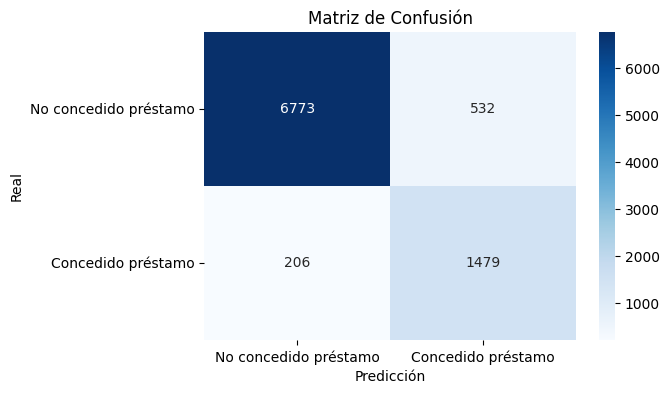

In [20]:
def objective(trial):
 bootstrap = trial.suggest_categorical('bootstrap', [True, False])
 max_depth = trial.suggest_int('max_depth', 5, 15)
 n_estimators = trial.suggest_int('n_estimators', 100, 300)
 model = RandomForestClassifier(bootstrap=bootstrap, max_depth=max_depth, n_estimators=n_estimators)
 return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print("Mejores hiperparámetros:", study.best_params)

modeloRFC = RandomForestClassifier(bootstrap=study.best_params['bootstrap'], max_depth=study.best_params['max_depth'], n_estimators=study.best_params['n_estimators'])

train_validation(modeloRFC, X_train, X_test, y_train, y_test)

### Conclusión del análisis: Revisión de desbalanceo de datos

Tras la primera ejecución del primer modelo, observamos que los scores de "No concesión de préstamo" son mucho mejores que los de "Concesión de préstamo". Vamos a analizar los datos del entrenamiento para ver si estos están equilibrados.

In [21]:
datosEntrenamiento = "Cantidad de datos de entrenamiento del dataset no normalizado:", y_train.value_counts()
print(datosEntrenamiento)

datosEntrenamientoNorm = "Cantidad de datos de entrenamiento del dataset normalizado:", y_norm_train.value_counts()
print(datosEntrenamientoNorm)

('Cantidad de datos de entrenamiento del dataset no normalizado:', loan_status
0    28003
1     7957
Name: count, dtype: int64)
('Cantidad de datos de entrenamiento del dataset normalizado:', loan_status
0    28003
1     7957
Name: count, dtype: int64)


El resultado muestra que el DataSet está desbalanceado y hay más casos de no concesión que de concesión, por lo que nuestro siguiente paso es equilibrar el DataSet.

In [22]:
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_norm_resampled, y_norm_resampled = smote.fit_resample(X_norm_train, y_norm_train)

datosEntrenamiento = "Cantidad de datos de entrenamiento después del balanceo en el dataset no normalizado:", y_resampled.value_counts()
datosEntrenamientoNorm = "Cantidad de datos de entrenamiento después del balanceo en el dataset normalizado:", y_norm_resampled.value_counts()
print(datosEntrenamiento)
print(datosEntrenamientoNorm)

('Cantidad de datos de entrenamiento después del balanceo en el dataset no normalizado:', loan_status
0    28003
1    28003
Name: count, dtype: int64)
('Cantidad de datos de entrenamiento después del balanceo en el dataset normalizado:', loan_status
0    28003
1    28003
Name: count, dtype: int64)


In [23]:
def objective(trial):
 bootstrap = trial.suggest_categorical('bootstrap', [True, False])
 max_depth = trial.suggest_int('max_depth', 5, 15)
 n_estimators = trial.suggest_int('n_estimators', 100, 300)
 model = RandomForestClassifier(bootstrap=bootstrap, max_depth=max_depth, n_estimators=n_estimators)
 return cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy').mean()

study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print("Mejores hiperparámetros:", study.best_params)

modeloRFC = RandomForestClassifier(bootstrap=study.best_params['bootstrap'], max_depth=study.best_params['max_depth'], n_estimators=study.best_params['n_estimators'])

train_validation(modeloRFC, X_resampled, X_test, y_resampled, y_test)

[I 2025-05-14 19:08:54,333] A new study created in memory with name: no-name-43f26d5e-6800-4b04-a35f-9ebba5cf65e5
[I 2025-05-14 19:09:23,829] Trial 0 finished with value: 0.9154205934089626 and parameters: {'bootstrap': True, 'max_depth': 14, 'n_estimators': 100}. Best is trial 0 with value: 0.9154205934089626.
[I 2025-05-14 19:10:17,833] Trial 1 finished with value: 0.904064477243588 and parameters: {'bootstrap': True, 'max_depth': 9, 'n_estimators': 300}. Best is trial 0 with value: 0.9154205934089626.
[W 2025-05-14 19:10:50,296] Trial 2 failed with parameters: {'bootstrap': False, 'max_depth': 7, 'n_estimators': 226} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\ESP\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ESP\AppData\Local\Temp\ipykernel_12368\2473970842.py", line 6, in objective
    return cross_val_score

KeyboardInterrupt: 

### Modelo: DecisionTreeClassifier para loan_status

[I 2025-01-22 17:53:40,179] A new study created in memory with name: no-name-17d13d65-3db0-4692-99f0-8143a5f81466
[I 2025-01-22 17:53:41,138] Trial 0 finished with value: 0.8892803874395827 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 19}. Best is trial 0 with value: 0.8892803874395827.
[I 2025-01-22 17:53:42,046] Trial 1 finished with value: 0.8893160969428454 and parameters: {'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 14}. Best is trial 1 with value: 0.8893160969428454.
[I 2025-01-22 17:53:43,034] Trial 2 finished with value: 0.8941369994303662 and parameters: {'criterion': 'log_loss', 'max_depth': 9, 'min_samples_split': 13}. Best is trial 2 with value: 0.8941369994303662.
[I 2025-01-22 17:53:44,162] Trial 3 finished with value: 0.9010113744881572 and parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 12}. Best is trial 3 with value: 0.9010113744881572.
[I 2025-01-22 17:53:44,987] Trial 4 finished with value: 0

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 12}
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      6686
           1       0.82      0.71      0.76      2304

    accuracy                           0.88      8990
   macro avg       0.86      0.83      0.84      8990
weighted avg       0.88      0.88      0.88      8990

score_test =  0.8848720800889878
score_train =  0.9407206370745992


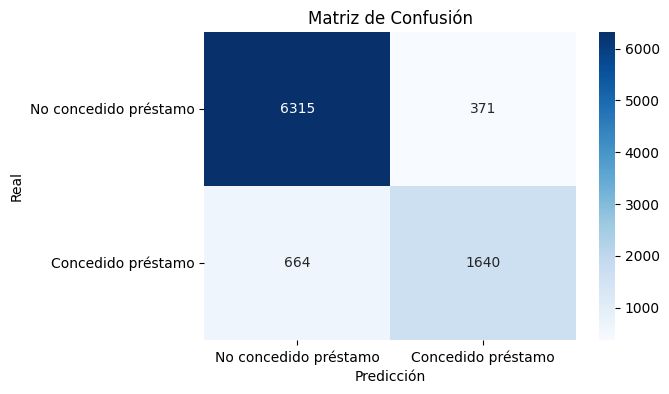

In [ ]:
def objective(trial):
 criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
 max_depth = trial.suggest_int('max_depth', 5, 15)
 min_samples_split = trial.suggest_int('min_samples_split', 10, 20)
 model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
 return cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy').mean()

study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=25)
print("Mejores hiperparámetros:", study.best_params)

modeloDTC = DecisionTreeClassifier(criterion=study.best_params['criterion'], max_depth=study.best_params['max_depth'], min_samples_split=study.best_params['min_samples_split'])

train_validation(modeloDTC, X_resampled, X_test, y_resampled, y_test)

### Modelo: KNeighborsClassifier para loan_status

[I 2025-01-22 17:53:59,282] A new study created in memory with name: no-name-a580a55f-57eb-4703-a8fe-10b5c655a5a3
[I 2025-01-22 17:54:01,091] Trial 0 finished with value: 0.9277042895445053 and parameters: {'metric': 'l2', 'n_neighbors': 7, 'weights': 'distance'}. Best is trial 0 with value: 0.9277042895445053.
[I 2025-01-22 17:56:17,061] Trial 1 finished with value: 0.9101347229993445 and parameters: {'metric': 'nan_euclidean', 'n_neighbors': 10, 'weights': 'uniform'}. Best is trial 0 with value: 0.9277042895445053.
[I 2025-01-22 17:56:21,254] Trial 2 finished with value: 0.9053852602398391 and parameters: {'metric': 'cityblock', 'n_neighbors': 15, 'weights': 'uniform'}. Best is trial 0 with value: 0.9277042895445053.
[I 2025-01-22 17:56:25,283] Trial 3 finished with value: 0.9101347229993445 and parameters: {'metric': 'l2', 'n_neighbors': 10, 'weights': 'uniform'}. Best is trial 0 with value: 0.9277042895445053.
[I 2025-01-22 17:56:27,282] Trial 4 finished with value: 0.9230440423635

Mejores hiperparámetros: {'metric': 'cosine', 'n_neighbors': 14, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      6491
           1       0.86      0.69      0.77      2499

    accuracy                           0.88      8990
   macro avg       0.88      0.83      0.85      8990
weighted avg       0.88      0.88      0.88      8990

score_test =  0.8838709677419355
score_train =  1.0


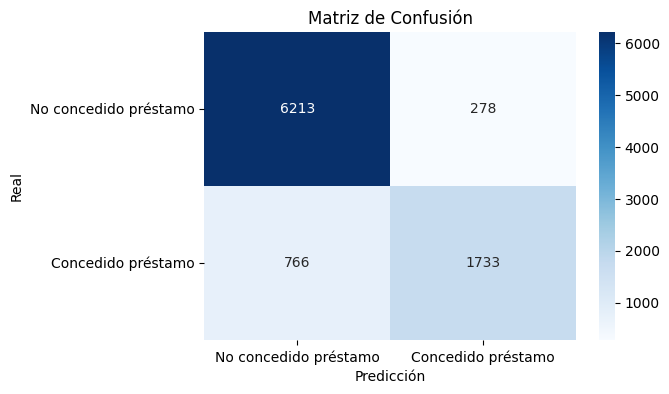

In [ ]:
def objective(trial):
 metric = trial.suggest_categorical('metric', ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'nan_euclidean'])
 n_neighbors = trial.suggest_int('n_neighbors', 5, 15)
 weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
 model = KNeighborsClassifier(metric=metric, n_neighbors=n_neighbors, weights=weights)
 return cross_val_score(model, X_norm_resampled, y_norm_resampled, cv=5, scoring='accuracy').mean()

study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print("Mejores hiperparámetros:", study.best_params)

modeloKNC = KNeighborsClassifier(metric=study.best_params['metric'], n_neighbors=study.best_params['n_neighbors'], weights=study.best_params['weights'])

train_validation(modeloKNC, X_norm_resampled, X_norm_test, y_norm_resampled, y_norm_test)

### Modelo: SVC para loan_status

[I 2025-01-22 17:58:59,342] A new study created in memory with name: no-name-e9d39108-23fd-4afe-9e34-01435c31992c
[I 2025-01-22 18:02:02,821] Trial 0 finished with value: 0.8834588617293381 and parameters: {'kernel': 'rbf', 'C': 5, 'gamma': 'auto'}. Best is trial 0 with value: 0.8834588617293381.
[I 2025-01-22 18:04:49,948] Trial 1 finished with value: 0.8806734088975942 and parameters: {'kernel': 'poly', 'C': 7, 'gamma': 'auto'}. Best is trial 0 with value: 0.8834588617293381.
[I 2025-01-22 18:09:07,534] Trial 2 finished with value: 0.8675141373561589 and parameters: {'kernel': 'linear', 'C': 15, 'gamma': 'auto'}. Best is trial 0 with value: 0.8834588617293381.


Mejores hiperparámetros: {'kernel': 'rbf', 'C': 5, 'gamma': 'auto'}
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      6015
           1       0.92      0.62      0.74      2975

    accuracy                           0.86      8990
   macro avg       0.88      0.80      0.82      8990
weighted avg       0.87      0.86      0.85      8990

score_test =  0.8580645161290322
score_train =  0.8846909259722172


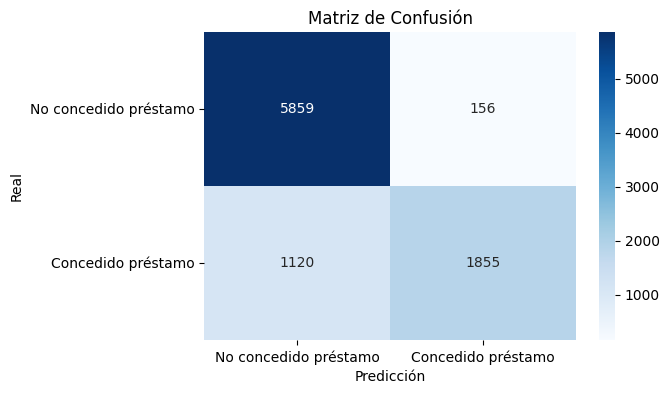

In [ ]:
def objective(trial):
 kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
 C = trial.suggest_int('C', 5, 15)
 gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
 model = SVC(kernel=kernel, C=C, gamma=gamma)
 return cross_val_score(model, X_norm_resampled, y_norm_resampled, cv=5, scoring='accuracy').mean()

study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=3)
print("Mejores hiperparámetros:", study.best_params)

modeloSVC = SVC(kernel=study.best_params['kernel'], C=study.best_params['C'], gamma=study.best_params['gamma'])

train_validation(modeloSVC, X_norm_resampled, X_norm_test, y_norm_resampled, y_norm_test)

### Modelo: XGBoostClassifier para loan_status

[I 2025-01-22 18:11:32,030] A new study created in memory with name: no-name-b92f40dc-16c9-4f03-805f-faadc6545fd9
[I 2025-01-22 18:11:35,012] Trial 0 finished with value: 0.9238842461859029 and parameters: {'max_depth': 5, 'learning_rate': 0.12245930559823429, 'n_estimators': 272, 'gamma': 0.49192144289138506}. Best is trial 0 with value: 0.9238842461859029.
[I 2025-01-22 18:11:37,455] Trial 1 finished with value: 0.9264552921657577 and parameters: {'max_depth': 14, 'learning_rate': 0.21673286248054258, 'n_estimators': 222, 'gamma': 0.5693781436944496}. Best is trial 1 with value: 0.9264552921657577.
[I 2025-01-22 18:11:39,478] Trial 2 finished with value: 0.9247413077373837 and parameters: {'max_depth': 6, 'learning_rate': 0.43750134333265744, 'n_estimators': 294, 'gamma': 0.6082148493098696}. Best is trial 1 with value: 0.9264552921657577.
[I 2025-01-22 18:11:41,351] Trial 3 finished with value: 0.9238126343101236 and parameters: {'max_depth': 14, 'learning_rate': 0.4831795243318605,

Mejores hiperparámetros: {'max_depth': 11, 'learning_rate': 0.28742236067295074, 'n_estimators': 100, 'gamma': 0.30011210726956766}
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6793
           1       0.84      0.76      0.80      2197

    accuracy                           0.91      8990
   macro avg       0.88      0.86      0.87      8990
weighted avg       0.90      0.91      0.90      8990

score_test =  0.9056729699666296
score_train =  0.9703246080777059


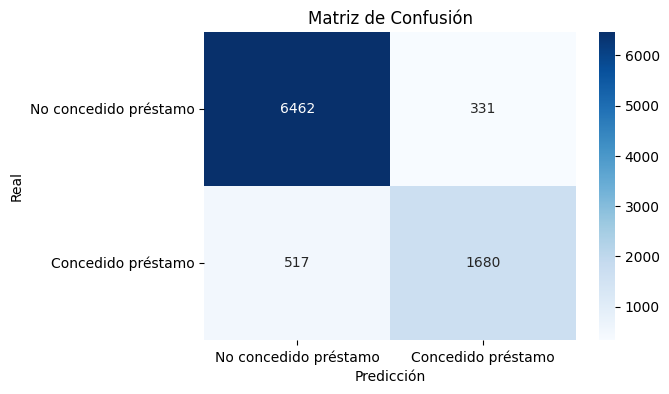

In [ ]:
def objective(trial):
 max_depth = trial.suggest_int('max_depth', 5, 15)
 learning_rate = trial.suggest_float('learning_rate', 0.1, 0.5)
 n_estimators = trial.suggest_int('n_estimators', 100, 300)
 gamma = trial.suggest_float('gamma', 0.3, 0.8)

 model = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, gamma=gamma)
 return cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy').mean()

study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Mejores hiperparámetros:", study.best_params)

modeloXGBC = XGBClassifier(max_depth=study.best_params['max_depth'], learning_rate=study.best_params['learning_rate'], n_estimators=study.best_params['n_estimators'], gamma=study.best_params['gamma'])

train_validation(modeloXGBC, X_resampled, X_test, y_resampled, y_test)

## Modelo elegido para loan_status: XGBoost

## Trabajando con risk_score

In [21]:
columnasRelevantesRiskScore = ["age", "yrs_exp", "cred_hist_length", "previous_loans_Yes"]

datosRiskScoreNormalized = datos[columnasRelevantesRiskScore + [valor_objetivo2]]

datosRiskScoreNormalized.head()

,age,yrs_exp,cred_hist_length,previous_loans_Yes,risk_score
0,22,0,3.0,0,561
1,21,0,2.0,1,504
2,25,3,3.0,0,635
3,23,0,2.0,0,675
4,24,1,4.0,0,586


### Escalado y normalización de datos

Vamos a realizar una copia del DataFrame de las columnas elegidas para la métrica de risk_score, uno con los valores sin escalar y otro con los valores normalizados, ya que dependiendo del modelo a probar, introduciremos uno u otro DataFrame.

In [22]:
se = StandardScaler()

for i in columnasRelevantesRiskScore:
    datosRiskScoreNormalized[i] = se.fit_transform(datosRiskScoreNormalized[[i]])

datosRiskScoreNormalized.head()

,age,yrs_exp,cred_hist_length,previous_loans_Yes,risk_score
0,-0.975128,-0.912677,-0.739496,0,561
1,-1.144849,-0.912677,-0.997570,1,504
2,-0.465967,-0.404856,-0.739496,0,635
3,-0.805408,-0.912677,-0.997570,0,675
4,-0.635687,-0.743403,-0.481423,0,586


### Análisis exploratorio de datos

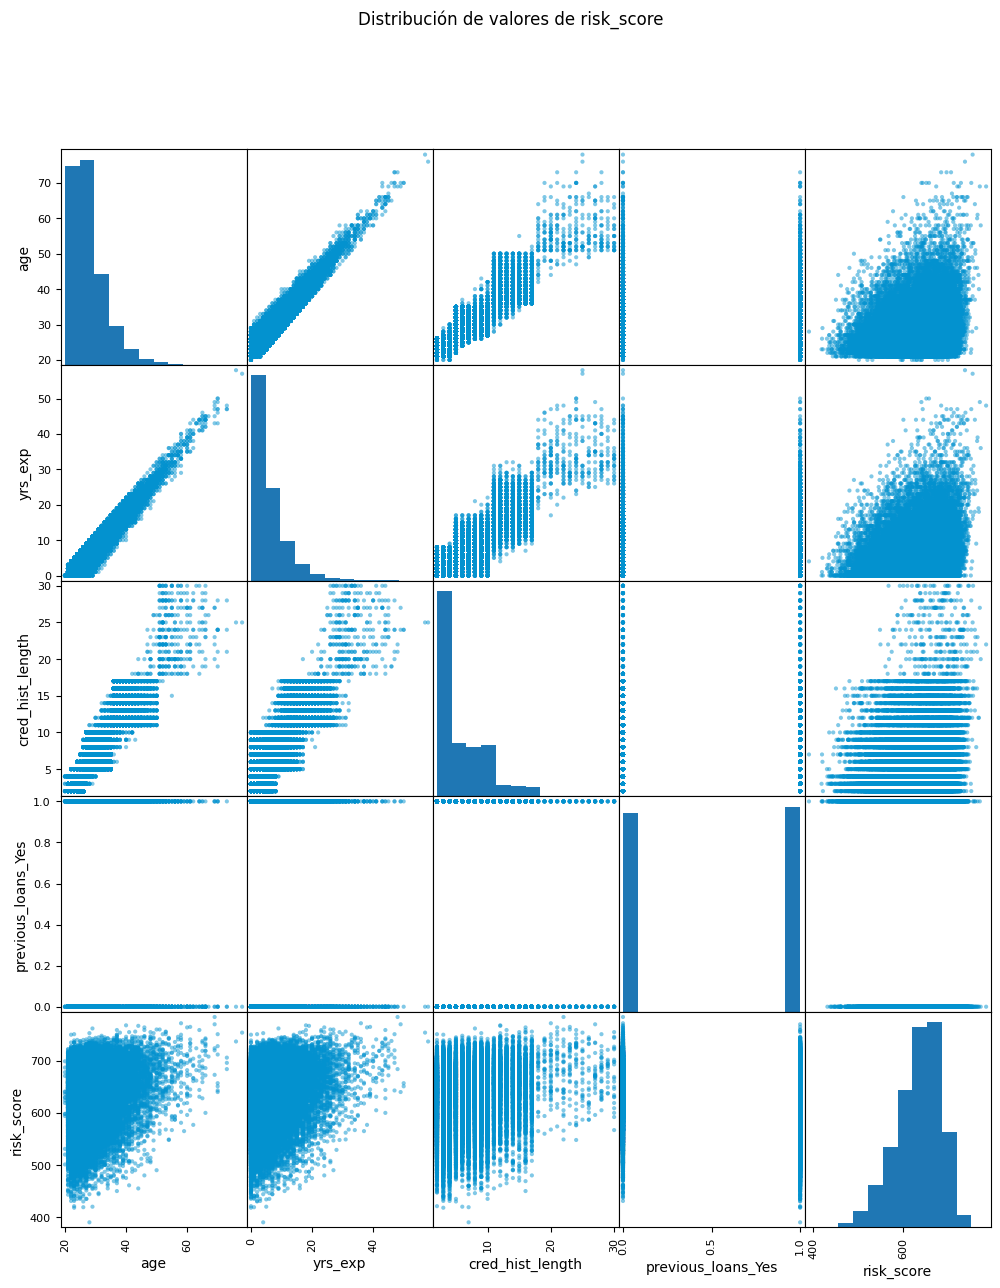

In [23]:
pd.plotting.scatter_matrix(datosRiskScoreNormalized, alpha=0.5, c='#0392cf', figsize=(12,14), diagonal='hist', hist_kwds={'bins':12})

plt.suptitle('Distribución de valores de risk_score')
plt.show()

Vista la gráfica anterior, vemos lo siguiente:

- Cuanto más crece el valor de 'age', más sube el valor de 'risk_score'. Esto mismo ocurre con las columnas 'yrs_exp' y 'cred_hist_length'.
- En la columna 'previous_loans_Yes' no observamos nada determinante en la gráfica de correlación.

### Desarrollo del modelo para risk_score

A continuación vamos a utilizar diferentes modelos para predecir la variable risk_score. Los modelos a utilizar para hacer la predicción de risk_score son orientados a regresión. También incluiremos un entrenamiento de hiperparámetros para obtener los mejores resultados.

In [24]:
def metrica(valores_reales, valores_predichos):
 mae = mean_absolute_error(valores_reales, valores_predichos)
 mse = mean_squared_error(valores_reales, valores_predichos)
 r2 = r2_score(valores_reales, valores_predichos)

 return ["Error absoluto medio: " + str(mae), "Error cuadrático medio: " + str(mse), "Coeficiente de determinación: " + str(r2)]

def train_validation_regression(modelo, X_train, y_train, X_test, y_test):
 modelo.fit(X_train, y_train)
 y_pred = modelo.predict(X_test)

 error_val = metrica(y_test, y_pred)

 print(f'Métrica para datos de validación:')
 for i in error_val:
  print(i)
 
 print('score_test = ', modelo.score(X_test, y_test))
 print('score_train = ', modelo.score(X_train, y_train))

X_normalized = datosRiskScoreNormalized.drop('risk_score',axis=1)
y_normalized = datosRiskScoreNormalized['risk_score']

X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

### Modelo: LogisticRegression para risk_score

In [25]:
def objective(trial):
 penalty = trial.suggest_categorical('penalty', ['l2'])
 C = trial.suggest_float('C', 1.0, 3.0)
 solver = trial.suggest_categorical('solver', ['lbfgs'])
 max_iter = trial.suggest_int('max_iter', 1000, 3000)
 model = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=max_iter)
 return cross_val_score(model, X_norm_train, y_norm_train, cv=5, scoring='neg_mean_absolute_error').mean()

study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
print("Mejores hiperparámetros:", study.best_params)

modeloLRRiskScore = LogisticRegression(penalty=study.best_params['penalty'], C=study.best_params['C'], solver=study.best_params['solver'], max_iter=study.best_params['max_iter'])

train_validation_regression(modeloLRRiskScore, X_norm_train, y_norm_train, X_norm_test, y_norm_test)

[I 2025-01-15 00:16:08,078] A new study created in memory with name: no-name-3fc8d4d4-870b-4d00-a4d9-ad6bec3f6678
c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
[I 2025-01-15 00:16:40,299] Trial 0 finished with value: -41.56209677419355 and parameters: {'penalty': 'l2', 'C': 2.4424186091554434, 'solver': 'lbfgs', 'max_iter': 2758}. Best is trial 0 with value: -41.56209677419355.
c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
[I 2025-01-15 00:17:13,789] Trial 1 finished with value: -41.59240823136819 and parameters: {'penalty': 'l2', 'C': 1.6752828870891927, 'solver': 'lbfgs', 'max_iter': 2539}. Best is trial 0 with value: -41.562096774193

Mejores hiperparámetros: {'penalty': 'l2', 'C': 1.435335868337743, 'solver': 'lbfgs', 'max_iter': 1953}
Métrica para datos de validación:
Error absoluto medio: 41.29421579532814
Error cuadrático medio: 2900.4119021134593
Coeficiente de determinación: -0.14330216705897003
score_test =  0.00778642936596218
score_train =  0.010734149054505005


### Modelo: DecisionTreeRegressor para risk_score

In [26]:
def objective(trial):
 criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse'])
 max_depth = trial.suggest_int('max_depth', 5, 15)
 min_samples_split = trial.suggest_int('min_samples_split', 10, 20)
 model = DecisionTreeRegressor(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
 return cross_val_score(model, X_norm_train, y_norm_train, cv=5, scoring='neg_mean_absolute_error').mean()

study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print("Mejores hiperparámetros:", study.best_params)

modeloDTR = DecisionTreeRegressor(criterion=study.best_params['criterion'], max_depth=study.best_params['max_depth'], min_samples_split=study.best_params['min_samples_split'])

train_validation_regression(modeloDTR, X_norm_train, y_norm_train, X_norm_test, y_norm_test)

[I 2025-01-15 00:18:54,375] A new study created in memory with name: no-name-8fd5d7ed-bcb5-4b1d-8ece-f1dd6ecb784a
[I 2025-01-15 00:18:54,495] Trial 0 finished with value: -40.11278561875714 and parameters: {'criterion': 'squared_error', 'max_depth': 15, 'min_samples_split': 11}. Best is trial 0 with value: -40.11278561875714.
[I 2025-01-15 00:18:54,575] Trial 1 finished with value: -39.25776116907711 and parameters: {'criterion': 'squared_error', 'max_depth': 8, 'min_samples_split': 14}. Best is trial 1 with value: -39.25776116907711.
[I 2025-01-15 00:18:54,658] Trial 2 finished with value: -39.21260704225475 and parameters: {'criterion': 'squared_error', 'max_depth': 7, 'min_samples_split': 15}. Best is trial 2 with value: -39.21260704225475.
[I 2025-01-15 00:18:54,736] Trial 3 finished with value: -39.25996639209227 and parameters: {'criterion': 'friedman_mse', 'max_depth': 8, 'min_samples_split': 16}. Best is trial 2 with value: -39.21260704225475.
[I 2025-01-15 00:18:54,852] Trial 

Mejores hiperparámetros: {'criterion': 'squared_error', 'max_depth': 7, 'min_samples_split': 19}
Métrica para datos de validación:
Error absoluto medio: 39.322908463090144
Error cuadrático medio: 2399.4188624370886
Coeficiente de determinación: 0.05418234454646098
score_test =  0.05418234454646098
score_train =  0.07282074745442535


### Modelo: RandomForestRegressor para risk_score

In [27]:
def objective(trial):
 bootstrap = trial.suggest_categorical('bootstrap', [True, False])
 max_depth = trial.suggest_int('max_depth', 5, 15)
 n_estimators = trial.suggest_int('n_estimators', 100, 300)
 model = RandomForestRegressor(bootstrap=bootstrap, max_depth=max_depth, n_estimators=n_estimators)
 return cross_val_score(model, X_norm_train, y_norm_train, cv=5, scoring='neg_mean_absolute_error').mean()

study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print("Mejores hiperparámetros:", study.best_params)

modeloRFR = RandomForestRegressor(bootstrap=study.best_params['bootstrap'], max_depth=study.best_params['max_depth'], n_estimators=study.best_params['n_estimators'])

train_validation_regression(modeloRFR, X_norm_train, y_norm_train, X_norm_test, y_norm_test)

[I 2025-01-15 00:18:55,323] A new study created in memory with name: no-name-38e94855-e313-4b96-9e48-a158ece14200
[I 2025-01-15 00:19:10,481] Trial 0 finished with value: -40.19916796334033 and parameters: {'bootstrap': False, 'max_depth': 13, 'n_estimators': 186}. Best is trial 0 with value: -40.19916796334033.
[I 2025-01-15 00:19:23,095] Trial 1 finished with value: -40.199106817269026 and parameters: {'bootstrap': False, 'max_depth': 13, 'n_estimators': 148}. Best is trial 1 with value: -40.199106817269026.
[I 2025-01-15 00:19:38,997] Trial 2 finished with value: -39.24658990812178 and parameters: {'bootstrap': False, 'max_depth': 7, 'n_estimators': 253}. Best is trial 2 with value: -39.24658990812178.
[I 2025-01-15 00:20:01,449] Trial 3 finished with value: -39.99184023388652 and parameters: {'bootstrap': False, 'max_depth': 12, 'n_estimators': 252}. Best is trial 2 with value: -39.24658990812178.
[I 2025-01-15 00:20:23,044] Trial 4 finished with value: -40.50561837777691 and param

Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 6, 'n_estimators': 214}
Métrica para datos de validación:
Error absoluto medio: 39.14240687529763
Error cuadrático medio: 2374.242557337033
Coeficiente de determinación: 0.0641064950295207
score_test =  0.0641064950295207
score_train =  0.07270179185320036


### Modelo: KNeighborsRegressor para risk_score

In [28]:
def objective(trial):
 metric = trial.suggest_categorical('metric', ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'nan_euclidean'])
 n_neighbors = trial.suggest_int('n_neighbors', 5, 15)
 weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
 model = KNeighborsRegressor(metric=metric, n_neighbors=n_neighbors, weights=weights)
 return cross_val_score(model, X_norm_train, y_norm_train, cv=5, scoring='neg_mean_absolute_error').mean()

study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print("Mejores hiperparámetros:", study.best_params)

modeloKNR = KNeighborsRegressor(metric=study.best_params['metric'], n_neighbors=study.best_params['n_neighbors'], weights=study.best_params['weights'])

train_validation_regression(modeloKNR, X_norm_train, y_norm_train, X_norm_test, y_norm_test)

[I 2025-01-15 00:21:21,070] A new study created in memory with name: no-name-6b4a3d79-bd52-4068-81d2-86adbf9e3450
[I 2025-01-15 00:21:21,476] Trial 0 finished with value: -41.278253615127916 and parameters: {'metric': 'cityblock', 'n_neighbors': 7, 'weights': 'uniform'}. Best is trial 0 with value: -41.278253615127916.
[I 2025-01-15 00:21:57,421] Trial 1 finished with value: -40.19231288733514 and parameters: {'metric': 'nan_euclidean', 'n_neighbors': 14, 'weights': 'uniform'}. Best is trial 1 with value: -40.19231288733514.
[I 2025-01-15 00:21:57,855] Trial 2 finished with value: -41.153550196153965 and parameters: {'metric': 'l1', 'n_neighbors': 13, 'weights': 'distance'}. Best is trial 1 with value: -40.19231288733514.
[I 2025-01-15 00:21:58,219] Trial 3 finished with value: -41.92636541637111 and parameters: {'metric': 'cityblock', 'n_neighbors': 7, 'weights': 'distance'}. Best is trial 1 with value: -40.19231288733514.
[I 2025-01-15 00:22:31,278] Trial 4 finished with value: -40.7

Mejores hiperparámetros: {'metric': 'cityblock', 'n_neighbors': 15, 'weights': 'uniform'}
Métrica para datos de validación:
Error absoluto medio: 40.114111976269925
Error cuadrático medio: 2509.0418578667654
Coeficiente de determinación: 0.010970479313485382
score_test =  0.010970479313485382
score_train =  0.06766787826651866


### Modelo: SVR para risk_score

Reducimos los trials a probar por el tunning de hiperparámetros, ya que el tiempo de ejecución se elevaba demasiado.

In [29]:
def objective(trial):
 kernel = trial.suggest_categorical('kernel', ['rbf'])
 C = trial.suggest_int('C', 5, 15)
 gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
 model = SVR(kernel=kernel, C=C, gamma=gamma)
 return cross_val_score(model, X_norm_train, y_norm_train, cv=5, scoring='neg_mean_absolute_error').mean()

study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=3)
print("Mejores hiperparámetros:", study.best_params)

modeloSVR = SVR(kernel=study.best_params['kernel'], C=study.best_params['C'], gamma=study.best_params['gamma'])

train_validation_regression(modeloSVR, X_norm_train, y_norm_train, X_norm_test, y_norm_test)

[I 2025-01-15 00:23:32,249] A new study created in memory with name: no-name-49fc87e5-8180-436e-b429-a6928caef172
[I 2025-01-15 00:25:53,991] Trial 0 finished with value: -38.68495150628282 and parameters: {'kernel': 'rbf', 'C': 13, 'gamma': 'auto'}. Best is trial 0 with value: -38.68495150628282.
[I 2025-01-15 00:28:14,881] Trial 1 finished with value: -38.68330643664201 and parameters: {'kernel': 'rbf', 'C': 8, 'gamma': 'auto'}. Best is trial 1 with value: -38.68330643664201.
[I 2025-01-15 00:30:50,949] Trial 2 finished with value: -38.68495150628282 and parameters: {'kernel': 'rbf', 'C': 13, 'gamma': 'auto'}. Best is trial 1 with value: -38.68330643664201.


Mejores hiperparámetros: {'kernel': 'rbf', 'C': 8, 'gamma': 'auto'}
Métrica para datos de validación:
Error absoluto medio: 38.73593222000249
Error cuadrático medio: 2412.6677283471818
Coeficiente de determinación: 0.0489598252570298
score_test =  0.0489598252570298
score_train =  0.04884164691858284


### Modelo: XGBoost para risk_score

In [30]:
def objective(trial):
 max_depth = trial.suggest_int('max_depth', 5, 15)
 learning_rate = trial.suggest_float('learning_rate', 0.1, 0.5)
 n_estimators = trial.suggest_int('n_estimators', 100, 300)
 gamma = trial.suggest_float('gamma', 0.3, 0.8)

 model = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, gamma=gamma)
 return cross_val_score(model, X_norm_train, y_norm_train, cv=5, scoring='neg_mean_absolute_error').mean()

study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Mejores hiperparámetros:", study.best_params)

modeloXGBR = XGBRegressor(max_depth=study.best_params['max_depth'], learning_rate=study.best_params['learning_rate'], n_estimators=study.best_params['n_estimators'], gamma=study.best_params['gamma'])

train_validation_regression(modeloXGBR, X_norm_train, y_norm_train, X_norm_test, y_norm_test)

[I 2025-01-15 00:33:18,785] A new study created in memory with name: no-name-b46ea7c2-4cb4-4ca5-aeca-73ed720117ae
[I 2025-01-15 00:33:20,548] Trial 0 finished with value: -40.5870496442241 and parameters: {'max_depth': 14, 'learning_rate': 0.2701830518452423, 'n_estimators': 230, 'gamma': 0.5806798007448245}. Best is trial 0 with value: -40.5870496442241.
[I 2025-01-15 00:33:22,555] Trial 1 finished with value: -40.567755771929754 and parameters: {'max_depth': 14, 'learning_rate': 0.21705070516627503, 'n_estimators': 143, 'gamma': 0.49195895862534916}. Best is trial 1 with value: -40.567755771929754.
[I 2025-01-15 00:33:24,404] Trial 2 finished with value: -40.37743804643098 and parameters: {'max_depth': 9, 'learning_rate': 0.2788785136460388, 'n_estimators': 206, 'gamma': 0.7883672581806992}. Best is trial 2 with value: -40.37743804643098.
[I 2025-01-15 00:33:27,886] Trial 3 finished with value: -40.37114637584919 and parameters: {'max_depth': 12, 'learning_rate': 0.10436616466728972,

Mejores hiperparámetros: {'max_depth': 5, 'learning_rate': 0.12199410597812288, 'n_estimators': 104, 'gamma': 0.7926908224766097}
Métrica para datos de validación:
Error absoluto medio: 39.25302291038437
Error cuadrático medio: 2387.7059739925194
Coeficiente de determinación: 0.05879944562911987
score_test =  0.05879944562911987
score_train =  0.08382058143615723


## Modelo elegido para risk_score: RandomForestRegressor

Tras probar varios modelos y revisar las diferentes métricas de validación, el método más acertado es RandomForestRegressor. Las razones son las siguientes:

- A pesar de no tener el valor más bajo de Error absoluto medio (El más bajo lo tiene el modelo SVR), el resto de valores, como el Error cuadrático medio y el coeficiente de determinación tienen valores bastante más aceptables que otros modelos.
- Hay una diferencia bastante pequeña entre el score de train y de test.

## Pruebas de predicciones de modelos
Tras haber elegido los modelos de predicción para las columnas objetivo loan_status y risk_score, el siguiente paso es realizar una predicción con datos inventados, y ver si cada modelo es capaz de realizar la predicción correctamente. Crearemos un DataFrame rellenado con datos inventados y le pasaremos al modelo esta información.

### Modelo KNeighborsClassifier para loan_status

In [31]:
def validation_classifier(model, X_prueba, y_prueba):
    y_pred = model.predict(X_prueba)
    print(classification_report(y_pred, y_prueba.astype(int)))
    print('score_test = ', model.score(X_prueba, y_prueba.astype(int)))

c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

score_test =  1.0


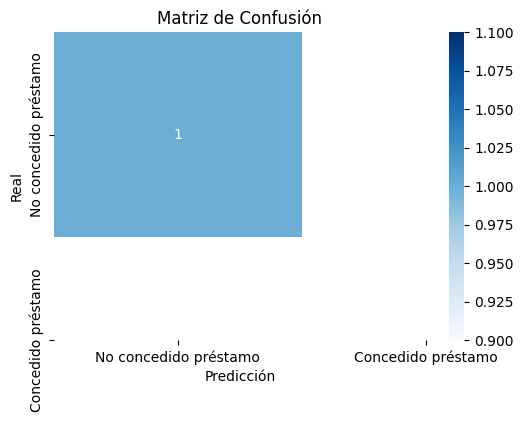

In [32]:
dataLoanStatus = {
    "income": [89000.0],
    "int_rate": [44.23],
    "percent_income": [0.76],
    "ownership_MORTGAGE": [1],
    "ownership_RENT": [0],
    "previous_loans_Yes": [0],
    "loan_status": [0]
}

dfLoanStatus = pd.DataFrame(dataLoanStatus)

dfLoanStatus["income"] = se.fit_transform(dfLoanStatus[["income"]])
dfLoanStatus["int_rate"] = se.fit_transform(dfLoanStatus[["int_rate"]])
dfLoanStatus["percent_income"] = se.fit_transform(dfLoanStatus[["percent_income"]])

X_prueba_loan = dfLoanStatus.drop('loan_status',axis=1)
y_prueba_loan = dfLoanStatus['loan_status']

validation_classifier(modeloKNC, X_prueba_loan, y_prueba_loan)

### Modelo RandomForestRegression para risk_score

In [33]:
def metrica(valores_reales, valores_predichos):
 mae = mean_absolute_error(valores_reales, valores_predichos)
 mse = mean_squared_error(valores_reales, valores_predichos)
 r2 = r2_score(valores_reales, valores_predichos)

 return ["Error absoluto medio: " + str(mae), "Error cuadrático medio: " + str(mse), "Coeficiente de determinación: " + str(r2)]

def validation_regression(modelo, X_prueba, y_prueba):
 y_pred = modelo.predict(X_prueba)
 error_val = metrica(y_prueba, y_pred)

 print(f'Métrica para datos de validación:')
 for i in error_val:
  print(i)
 
 print('score_test = ', modelo.score(X_prueba, y_prueba))

In [34]:
dataRiskScore = {
    "age": [26],
    "yrs_exp": [10],
    "cred_hist_length": [4.0],
    "previous_loans_Yes": [1],
    "risk_score": [119]
}

dfRiskScore = pd.DataFrame(dataRiskScore)

X_prueba_risk = dfRiskScore.drop('risk_score',axis=1)
y_prueba_risk = dfRiskScore['risk_score']

validation_regression(modeloRFR, X_prueba_risk, y_prueba_risk)

Métrica para datos de validación:
Error absoluto medio: 511.57232727073927
Error cuadrático medio: 261706.24602920035
Coeficiente de determinación: nan
score_test =  nan


c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


## Conclusión

Tras revisar ambos casos de uso, podemos observar que el que mejor resultados tiene y es más fiable es el modelo de clasificación. El modelo de regresión, a pesar de haber elegido el que mejores valores daba, obtenemos un dato predicho bastante alejado del real, por lo que, por nuestra parte, no es un modelo fiable.